In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from PIL import Image, ImageDraw
import json
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
# Custom Dataset Class
class FaceRecognitionDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        sample_annotations = self.annotations[img_name]

        boxes = []
        names = []

        for annotation in sample_annotations:
            face_location = annotation['face_location']
            name = annotation['name']

            # Scale bounding box coordinates
            scale_x = 224.0 / original_size[0]
            scale_y = 224.0 / original_size[1]

            box_scaled = [
                int(face_location['left'] * scale_x),
                int(face_location['top'] * scale_y),
                int(face_location['right'] * scale_x),
                int(face_location['bottom'] * scale_y)
            ]

            boxes.append(box_scaled)
            names.append(name)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert list of boxes to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float)

        return image, boxes_tensor, names


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Custom collate function for DataLoader
def collate_fn(batch):
    images = []
    all_boxes = []
    all_names = []
    for b in batch:
        images.append(b[0])
        all_boxes.append(b[1])
        all_names.append(b[2])
    images = torch.stack(images)
    return images, all_boxes, all_names

In [ ]:
# Function to partition dataset
def partition_dataset(annotations, train_frac=0.8, val_frac=0.1):
    total_samples = len(annotations)
    train_size = int(total_samples * train_frac)
    val_size = int(total_samples * val_frac)
    test_size = total_samples - train_size - val_size

    keys = list(annotations.keys())
    random.shuffle(keys)
    train_keys = keys[:train_size]
    val_keys = keys[train_size:train_size + val_size]
    test_keys = keys[train_size + val_size:]

    train_annotations = {k: annotations[k] for k in train_keys}
    val_annotations = {k: annotations[k] for k in val_keys}
    test_annotations = {k: annotations[k] for k in test_keys}

    print(f"Dataset partitioned into {len(train_annotations)} training, {len(val_annotations)} validation, and {len(test_annotations)} test samples.")

    return train_annotations, val_annotations, test_annotations

In [ ]:
# Load Annotations
annotations_path = '/content/drive/MyDrive/Face/annotations_updated.json'  # Replace with your actual annotations file path
with open(annotations_path) as f:
    annotations = json.load(f)

# Partition the dataset into training, validation, and test sets
train_annotations, val_annotations, test_annotations = partition_dataset(annotations)
train_annotations1, val_annotations1, test_annotations1 = partition_dataset(annotations, 0.01, 0.495)

# Initialize Dataset and Dataloader
root_dir = '/content/drive/MyDrive/dataset'  # Replace with your actual images directory path

Dataset partitioned into 160 training, 20 validation, and 20 test samples.
Dataset partitioned into 2 training, 99 validation, and 99 test samples.


In [ ]:

# Transforms for training, validation and test datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define datasets
train_dataset = FaceRecognitionDataset(train_annotations, root_dir, transform=train_transform)
val_dataset = FaceRecognitionDataset(val_annotations, root_dir, transform=val_test_transform)
test_dataset = FaceRecognitionDataset(test_annotations, root_dir, transform=val_test_transform)
train_dataset1 = FaceRecognitionDataset(train_annotations1, root_dir, transform=train_transform)

In [ ]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
train_loader1 = DataLoader(train_dataset1, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Define the inv_normalize transform if you need to visualize images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# VGG11 Model (not used for visualization, provided for completeness)
#model = models.vgg11(pretrained=False)
#model.classifier[6] = nn.Linear(model.classifier[6].in_features, 128)

# Loss function and Optimizer (not used for visualization, provided for completeness)
#criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Visualization of images with bounding boxes and names
def show_image_with_boxes(image, boxes, names):
    draw = ImageDraw.Draw(image)
    for box, name in zip(boxes, names):
        # Draw bounding box and name
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)
        draw.text((box[0], box[1] - 10), name, fill="red")
    return image

Visualizing the first sample from the first mini-batch...


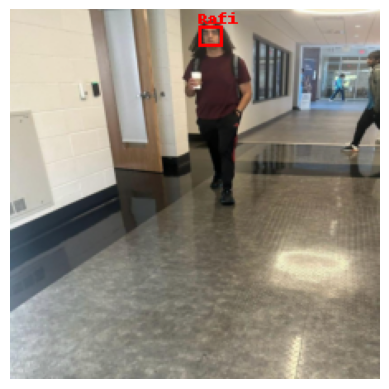

In [ ]:
# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(train_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[0]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[0], first_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn
# Create an instance of the MiniVGG model
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x




In [ ]:
model1 = MiniVGG()

In [ ]:
momentum_coefficient1 = 0.9
weight_decay1 = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.0001, betas=(momentum_coefficient1, 0.999), weight_decay=0.01)

In [ ]:
# Part - 1
# Training for only 2 images
# we can see really low losses
EPOCHS = 50
for epoch in range(EPOCHS):
  model1.train()
  total_loss = 0.0

  for batch in tqdm(train_loader1):
    image, bounding_box, _ = batch
    num_boxes = batch[0].size(0)
    optimizer.zero_grad()
    outputs = model1(image)
    outputs = outputs.view(num_boxes, 1, 4)
    #bounding_box = np.array(bounding_box)
    for i in range(len(bounding_box)):
      if bounding_box[i].numel() == 0:
        #bounding_box[i] = torch.empty(1,4)
        bounding_box[i] = torch.randint(0, 300, (1,4))
      elif bounding_box[i].shape != torch.Size([1, 4]):
        bounding_box[i] = bounding_box[i][:1]

    bounding_box = torch.stack(bounding_box)
    loss = criterion(outputs, bounding_box)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()/255/255

  average_loss = total_loss/len(train_loader)
  print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss: .4f}')


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch [1/50], Loss:  294.6952


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch [2/50], Loss:  294.1333


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Epoch [3/50], Loss:  293.1332


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch [4/50], Loss:  291.2404


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch [5/50], Loss:  287.8333


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch [6/50], Loss:  282.0251


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch [7/50], Loss:  272.5951


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch [8/50], Loss:  257.9088


100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Epoch [9/50], Loss:  235.9743


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch [10/50], Loss:  204.7080


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch [11/50], Loss:  162.7140


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch [12/50], Loss:  111.1653


 80%|████████  | 16/20 [04:12<01:03, 15.84s/it] [repeated 2x across cluster]



Epoch [13/50], Loss:  58.1125


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch [14/50], Loss:  27.8434


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch [15/50], Loss:  57.1065


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch [16/50], Loss:  76.2334


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch [17/50], Loss:  50.0665


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch [18/50], Loss:  19.5981


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch [19/50], Loss:  6.8889


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch [20/50], Loss:  9.9010


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch [21/50], Loss:  18.8824


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch [22/50], Loss:  26.3870


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Epoch [23/50], Loss:  29.6712


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch [24/50], Loss:  28.5233


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch [25/50], Loss:  24.1065


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch [26/50], Loss:  18.4353


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch [27/50], Loss:  14.0048


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch [28/50], Loss:  12.7637


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Epoch [29/50], Loss:  14.6434


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch [30/50], Loss:  16.8867


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch [31/50], Loss:  16.2949


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch [32/50], Loss:  12.5454


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch [33/50], Loss:  8.1431


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch [34/50], Loss:  5.5299


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch [35/50], Loss:  5.2589


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch [36/50], Loss:  6.3529


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch [37/50], Loss:  7.4786


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch [38/50], Loss:  7.7803


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch [39/50], Loss:  7.1306


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch [40/50], Loss:  5.9893


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch [41/50], Loss:  5.0774


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch [42/50], Loss:  4.9315


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch [43/50], Loss:  5.5060


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch [44/50], Loss:  6.1575


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch [45/50], Loss:  6.1813


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch [46/50], Loss:  5.4488


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch [47/50], Loss:  4.4526


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Epoch [48/50], Loss:  3.7704


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch [49/50], Loss:  3.5931


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

Epoch [50/50], Loss:  3.7027


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU')
else:
  device = torch.device('cpu')
  print('cpu')

cpu


In [ ]:
!pip install ray
!pip install -U tensorboardx

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
#from torchvision.datasets import YourDataset  # Replace with your actual dataset class

from ray import tune, train
from ray.tune.schedulers import ASHAScheduler


# Define the training function
def train_miniVGG(config):
    model = MiniVGG()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr = config["lr"],
        betas=(config["momentum"],0.99),
        weight_decay=config["weight_decay"],
    )

    # Training loop
    for epoch in range(5):
        model.train()

        running_loss = 0.0
        epoch_steps = 0
        for batch in tqdm(train_loader):
            image, bounding_box, _ = batch
            num_boxes = batch[0].size(0)
            optimizer.zero_grad()
            outputs = model(image)
            outputs = outputs.view(num_boxes, 1, 4)
        #bounding_box = np.array(bounding_box)
            for i in range(len(bounding_box)):
                if bounding_box[i].numel() == 0:
            #bounding_box[i] = torch.empty(1,4)
                    bounding_box[i] = torch.randint(0, 300, (1,4))
                elif bounding_box[i].shape != torch.Size([1, 4]):
                    bounding_box[i] = bounding_box[i][:1]


            bounding_box = torch.stack(bounding_box)
            loss = criterion(outputs, bounding_box)
            loss.backward()
            running_loss += loss.item()/255/255
            epoch_steps += 1
            optimizer.step()
        avg_loss = running_loss/len(train_loader)
        print(f'Epoch [{epoch+1}/5], Train_Loss: {avg_loss: .4f}')

        model.eval()
        total_loss_val = 0.0

        with torch.no_grad():
            for inputs, bounding_boxes,_ in val_loader:
                outputs = model(inputs)
                outputs = outputs.view(len(bounding_boxes), 1, 4)
        #bounding_box = np.array(bounding_box)
                for i in range(len(bounding_boxes)):
                    if bounding_box[i].numel() == 0:
                        bounding_box[i] == torch.randint(0, 300, (1,4))
                    elif bounding_boxes[i].shape != torch.Size([1, 4]):
                        bounding_boxes[i] = bounding_boxes[i][:1]

                bounding_boxes = torch.stack(bounding_boxes)
                val_loss = criterion(outputs, bounding_boxes)
                total_loss_val += val_loss.item()/255/255

            average_loss_val = total_loss_val / len(val_loader)
            print(f"Average Evaluation Loss: {average_loss_val:.4f}")
            '''total_loss += loss.item()

        average_loss = total_loss/len(train_loader)
        #loss_values.append(average_loss)
        print(f'Epoch [{epoch+1}/{5}], Loss: {average_loss: .4f}')'''
            train.report({'val_loss':average_loss_val})
# Define the Raytune configuration space
config = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "momentum": tune.uniform(0.1, 0.9),
    "weight_decay": tune.loguniform(1e-3, 0.5),
}

# Create the dataset and dataloaders
# dataset = YourDataset(...)  # Replace with your dataset initialization
# train_loader = DataLoader(dataset.train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(dataset.val_set, batch_size=64, shuffle=False)

# Define the Raytune scheduler
scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=5,
        grace_period=1,
        reduction_factor=2,
    )

# Perform hyperparameter tuning
analysis = tune.run(
    train_miniVGG,
    config=config,
    num_samples=20,  # Number of hyperparameter combinations to try
    scheduler = scheduler,
    max_failures = 3

)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric="val_loss", mode="min")

# Train the final model with the best hyperparameters on the entire training set


# Save or use the final_model for evaluation on the test set
# Evaluate and report performance on the test set
# test_loss, test_accuracy = evaluate_on_test_set(final_model, test_loader)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


2023-12-15 19:42:05,993	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------------------+
| Configuration for experiment     train_miniVGG_2023-12-15_19-42-06   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        AsyncHyperBandScheduler             |
| Number of trials                 20                                  |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_miniVGG_2023-12-15_19-42-06
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_miniVGG_2023-12-15_19-42-06`

Trial status: 16 PENDING
Current time: 2023-12-15 19:42:06. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------+
| Trial name                  status              lr     momentum     we

In [ ]:
# Training Final model could be better if higher epochs can be used
final_model = train_miniVGG(best_config)


In [ ]:
# validation losses
final_model.eval()
total_loss_val = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in val_loader:
        outputs = final_model(inputs)
        outputs = outputs.view(len(bounding_boxes), 1, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_val += loss.item()/255/255

    average_loss_val = total_loss_val / len(val_loader)
    print(f"Average Evaluation Loss: {average_loss_val:.4f}")


Average Evaluation Loss: 4041.3583


In [ ]:
# Test losses
final_model.eval()
total_loss_test = 0.0

with torch.no_grad():
    for inputs, bounding_boxes,_ in test_loader:
        outputs = final_model(inputs)
        outputs = outputs.view(len(bounding_boxes), 1, 4)
        #bounding_box = np.array(bounding_box)
        for i in range(len(bounding_boxes)):
          if bounding_box[i].numel() == 0:
            bounding_box[i] == torch.randint(0, 300, (1,4))
          elif bounding_boxes[i].shape != torch.Size([1, 4]):
            bounding_boxes[i] = bounding_boxes[i][:1]

        bounding_boxes = torch.stack(bounding_boxes)
        loss = criterion(outputs, bounding_boxes)
        total_loss_test += loss.item()/255/255

    average_loss_test = total_loss_test / len(test_loader)
    print(f"Average Evaluation Loss: {average_loss_test: .4f}")

Visualizing the first sample from the first mini-batch...


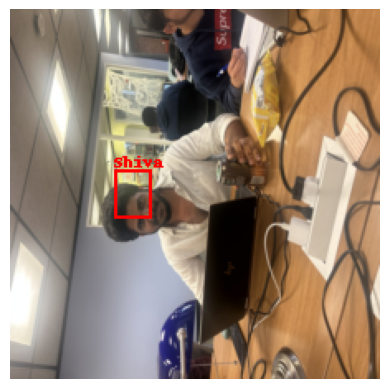

In [ ]:
# Get the first batch from the train loader
first_batch_images, first_batch_boxes, first_batch_names = next(iter(test_loader))

# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[0]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, first_batch_boxes[0], first_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

In [ ]:
output_test = model(first_batch_images)

In [ ]:
output = torch.tensor([[139.1185, 98.7528, 178.9293, 132.6456]])

In [ ]:
import numpy as np
output_test[3]

tensor([105.6487,  90.2524, 127.0676, 113.0892], grad_fn=<SelectBackward0>)

In [ ]:
first_batch_boxes[3]

tensor([[103.,  94., 126., 114.]])

In [ ]:
first_batch_images[0]

tensor([[[-0.1314, -0.0972, -0.0801,  ...,  1.2385,  1.1529,  1.1872],
         [-0.1143, -0.0972, -0.0801,  ...,  1.2557,  1.1700,  1.2043],
         [-0.0972, -0.0972, -0.0972,  ...,  1.2385,  1.1529,  1.2043],
         ...,
         [ 0.2624,  0.2624,  0.2282,  ..., -0.6109,  0.1597,  0.3994],
         [ 0.2282,  0.2111,  0.1768,  ..., -0.6109,  0.0398,  0.3652],
         [ 0.2111,  0.1426,  0.1254,  ..., -0.6281,  0.0056,  0.3652]],

        [[-0.2325, -0.1975, -0.1800,  ...,  0.3277,  0.2402,  0.2752],
         [-0.2150, -0.1975, -0.1800,  ...,  0.3452,  0.2577,  0.2927],
         [-0.2325, -0.2150, -0.1975,  ...,  0.3277,  0.2402,  0.2927],
         ...,
         [ 0.2052,  0.2052,  0.1702,  ..., -0.9853, -0.4426, -0.3025],
         [ 0.1702,  0.1527,  0.1176,  ..., -1.0028, -0.5476, -0.3375],
         [ 0.1527,  0.0826,  0.0651,  ..., -1.0028, -0.5651, -0.3200]],

        [[-0.2881, -0.2532, -0.2358,  ..., -0.4101, -0.4973, -0.4450],
         [-0.2707, -0.2532, -0.2358,  ..., -0

In [ ]:
output_test[3][0]

tensor(105.6487, grad_fn=<SelectBackward0>)

Visualizing the first sample from the first mini-batch...


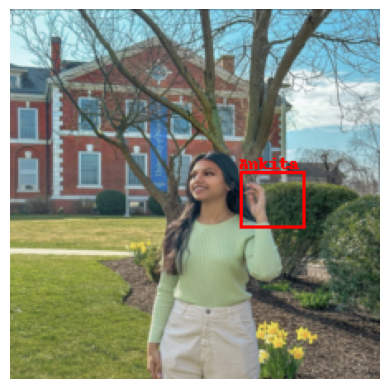

In [ ]:
# Apply inverse normalization to the first image in the first batch
first_image = inv_normalize(first_batch_images[3]).clamp(0, 1)
first_image_pil = transforms.ToPILImage()(first_image)

# Visualize the first sample from the first mini-batch
print("Visualizing the first sample from the first mini-batch...")
first_image_with_boxes = show_image_with_boxes(first_image_pil, output, first_batch_names[3])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()

This is the model output...


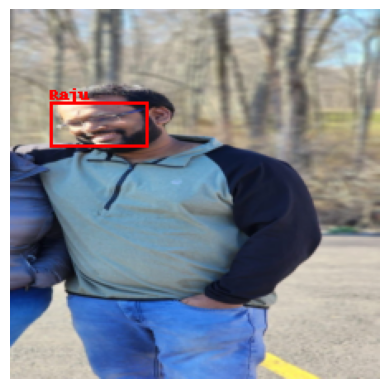

In [ ]:
# Get the output batch from the train loader
output_batch_images, output_batch_boxes, output_batch_names = next(iter(train_loader))

# Apply inverse normalization to the output image in the first batch
output_image = inv_normalize(output_batch_images[0]).clamp(0, 1)
output_image_pil = transforms.ToPILImage()(output_image)

# Visualize the first sample from the first mini-batch
print("This is the model output...")
first_image_with_boxes = show_image_with_boxes(output_image_pil, output_batch_boxes[0], output_batch_names[0])
plt.imshow(first_image_with_boxes)
plt.axis('off')
plt.show()